# Пример использования библиотеки BigARTM для тематического моделирования

**BigARTM 0.9.0**

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [5]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1})
# число после названия модальностей - это их веса

In [10]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [17]:
dictionary = artm.Dictionary(name='dictionary', data_path=batch_vectorizer.data_path)
dictionary.gather(data_path=batch_vectorizer.data_path)

In [18]:
model_artm.initialize("dictionary")

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [20]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

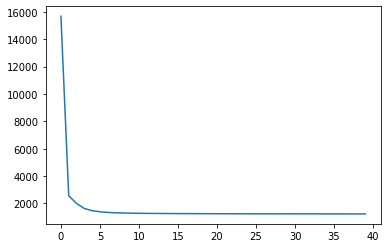

In [21]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [28]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ', end=" ")
    for word in model_artm.score_tracker["top_words"].las.tokens:
        print (word, end=" ")
    print

sbj0:  {'sbj0': ['что', 'быть', 'свой', 'для', 'мочь', 'это', 'они', 'время', 'человек', 'его', 'государство', 'являться', 'год', 'a', 'также'], 'sbj1': ['что', 'который', 'свой', 'этот', 'она', 'так', 'они', 'такой', 'это', 'x', 'герой', 'становиться', 'его', 'два', 'жизнь'], 'sbj2': ['который', 'быть', 'этот', 'как', 'такой', 'что', 'его', 'сила', 'один', 'так', 'они', 'тот', 'для', 'жизнь', 'герой'], 'sbj3': ['что', 'как', 'это', 'человек', 'такой', 'быть', 'этот', 'они', 'себя', 'так', 'два', 'x', 'государство', 'свой', 'первый'], 'sbj4': ['это', 'свой', 'что', 'один', 'себя', 'жизнь', 'мочь', 'также', 'который', 'век', 'если', 'однако', 'первый', 'функция', 'вид'], 'sbj5': ['быть', 'который', 'как', 'это', 'для', 'человек', 'x', 'год', 'сила', 'этот', 'при', 'a', 'мочь', 'такой', 'мир'], 'sbj6': ['быть', 'человек', 'что', 'этот', 'как', 'свой', 'жизнь', 'они', 'который', 'его', 'весь', 'самый', 'герой', 'первый', 'один'], 'sbj7': ['который', 'человек', 'для', 'весь', 'свой', 'быть

Давайте посмотрим также на разреженность матриц:

In [30]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7677122950553894
0.0018907563062384725


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [32]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary="dictionary"))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [35]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Попробуем менять коэффициент регуляризации:

In [40]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [41]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [42]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ', end=" ")
    for word in model_artm.score_tracker["top_words"].tokens:
        print (word, end=" ")
    print

sbj0:  {'sbj0': ['что', 'быть', 'свой', 'для', 'мочь', 'это', 'они', 'время', 'человек', 'его', 'государство', 'являться', 'год', 'a', 'также'], 'sbj1': ['что', 'который', 'свой', 'этот', 'она', 'так', 'они', 'такой', 'это', 'x', 'герой', 'становиться', 'его', 'два', 'жизнь'], 'sbj2': ['который', 'быть', 'этот', 'как', 'такой', 'что', 'его', 'сила', 'один', 'так', 'они', 'тот', 'для', 'жизнь', 'герой'], 'sbj3': ['что', 'как', 'это', 'человек', 'такой', 'быть', 'этот', 'они', 'себя', 'так', 'два', 'x', 'государство', 'свой', 'первый'], 'sbj4': ['это', 'свой', 'что', 'один', 'себя', 'жизнь', 'мочь', 'также', 'который', 'век', 'если', 'однако', 'первый', 'функция', 'вид'], 'sbj5': ['быть', 'который', 'как', 'это', 'для', 'человек', 'x', 'год', 'сила', 'этот', 'при', 'a', 'мочь', 'такой', 'мир'], 'sbj6': ['быть', 'человек', 'что', 'этот', 'как', 'свой', 'жизнь', 'они', 'который', 'его', 'весь', 'самый', 'герой', 'первый', 'один'], 'sbj7': ['который', 'человек', 'для', 'весь', 'свой', 'быть

In [43]:
# еще раз посмотрим на разреженность
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9009814262390137
0.09831932932138443


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [44]:
model_artm.save("my_model")

In [45]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [46]:
phi = model_artm.get_phi()

In [47]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
бета-частица,0.0,0.000000,0.0,0.000092,0.000000,0.0,0.000000,0.0,0.000000,0.0
фотопластинка,0.0,0.000000,0.0,0.000184,0.000000,0.0,0.000000,0.0,0.000000,0.0
толстостенный,0.0,0.000000,0.0,0.000092,0.000000,0.0,0.000000,0.0,0.000000,0.0
неоднородно,0.0,0.000000,0.0,0.000092,0.000000,0.0,0.000000,0.0,0.000000,0.0
неделимость,0.0,0.000000,0.0,0.000184,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
линдер,0.0,0.000138,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
ведущий,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.001883,0.0
Эйзентштейн,0.0,0.000138,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
чувственный,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000221,0.0,0.000000,0.0


Матрица вероятностей тем в документах.

In [48]:
theta = model_artm.get_theta()
theta

ValueError: cache_theta == False. Set ARTM.cache_theta = True

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [50]:
theta_test = model_artm.transform(batch_vectorizer)